## Bike Rent Forecasting Model

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('london_merged.csv')

In [3]:
df['timestamp']= pd.to_datetime(df['timestamp']) 
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [4]:
df['season'] = df['season'] +1     # adjust 'season' column to avoid zero values
df['hour'] = df['timestamp'].dt.hour+1    # add 'hour' to be used by the perceptron
# add category 'low' and 'high' to be used by the perceptron
df['category'] = np.where(df['cnt'] >= 1600, 'high', 'low')   
df.head(5)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,category
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,4.0,1,low
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,4.0,2,low
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,4.0,3,low
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,4.0,4,low
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,4.0,5,low


In [5]:
def plotting(dataframe):
    sns.set(color_codes=True)
    fig = plt.figure(figsize=(14,8))
    fig.suptitle('Number of bikes rented')
    ax1 = fig.add_subplot(2, 2, 1)
    sns.regplot(x='t1',y='cnt',data=dataframe,fit_reg=True, color="b", marker="+")
    ax1.set_xlabel('Temperature')
    ax2 = fig.add_subplot(2, 2, 2)
    sns.regplot(x='t2',y='cnt',data=dataframe,fit_reg=True, color="y", marker="+")
    ax2.set_xlabel('Feels-like temperature')
    ax3 = fig.add_subplot(2, 2, 3)
    sns.regplot(x='hum',y='cnt',data=dataframe,fit_reg=True, color="r", marker="+")
    ax3.set_xlabel('Humidity')
    ax4 = fig.add_subplot(2, 2, 4)
    sns.regplot(x='wind_speed',y='cnt',data=dataframe,fit_reg=True, color="g", marker="+")
    ax4.set_xlabel('wind-speed')

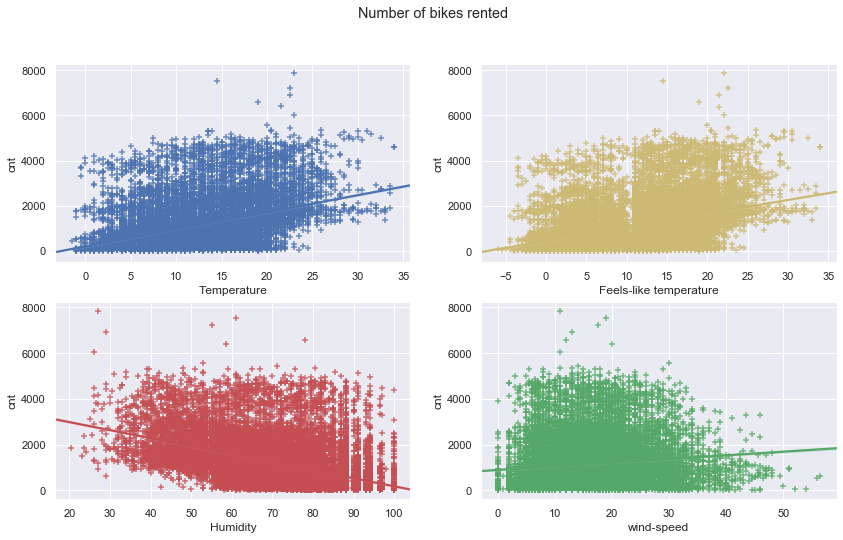

In [6]:
plotting(df)

## Training data - define Perceptron

In [7]:
class Perceptron(object):                   
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):                    
        self.w_ = np.zeros(1 + X.shape[1])  
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):                  #  Calculate net input
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):                    #  Return class label after unit step
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [8]:
def training(dataframe, epochs):     # df to include only the columns needed to X + last column for y
    y = dataframe['category'].values
    y = np.where(y == 'low', -1, 1) 
    X = dataframe.iloc[:, :-1].values
    ppn = Perceptron(eta=0.1, n_iter=epochs)
    ppn.fit(X, y)
    fig = plt.figure(figsize=(6,4))
    fig.set_facecolor('white')
    plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Number of misclassifications')
    plt.title('Number of misclassifications', fontsize=16)
    plt.show()
    accuracy = 1 - (ppn.errors_[epochs-1]) / len(dataframe.index)
    return accuracy

### Training data - all

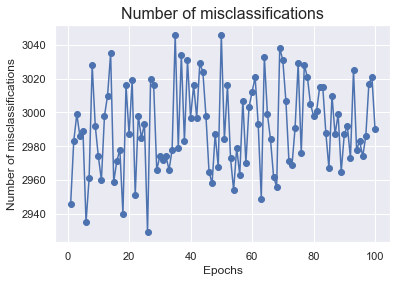

accuracy 82.83%


In [9]:
# training for full database
print(f'accuracy {training(df.iloc[:, 2:12], 100) * 100:.2f}%')

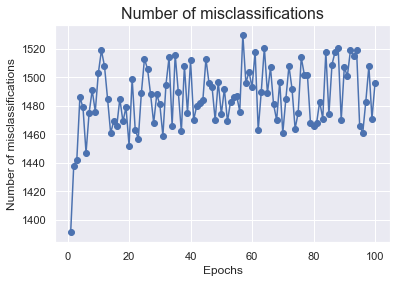

accuracy 82.69%


In [10]:
#training for year 2015, all features
df1 = df[df['timestamp'].dt.year == 2015]  
print(f'accuracy {training(df1.iloc[:, 2:12], 100) * 100:.2f}%')

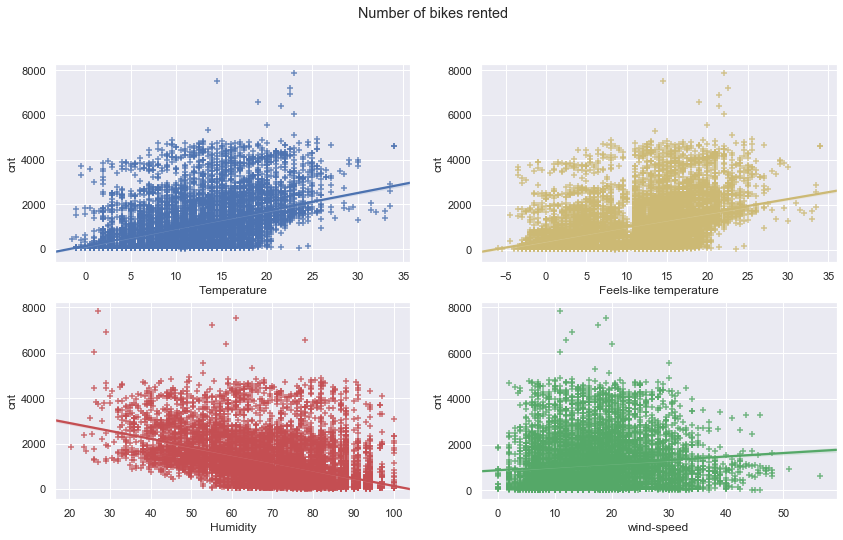

In [11]:
plotting(df1)

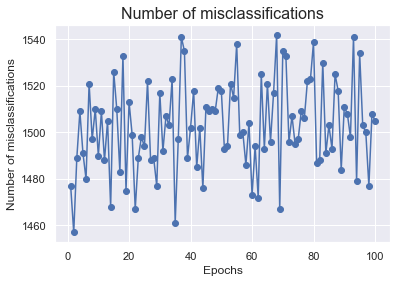

accuracy 82.70%


In [12]:
# training for year 2016, all features
df2 = df[df['timestamp'].dt.year == 2016] 
print(f'accuracy {training(df2.iloc[:, 2:12], 100) * 100:.2f}%')

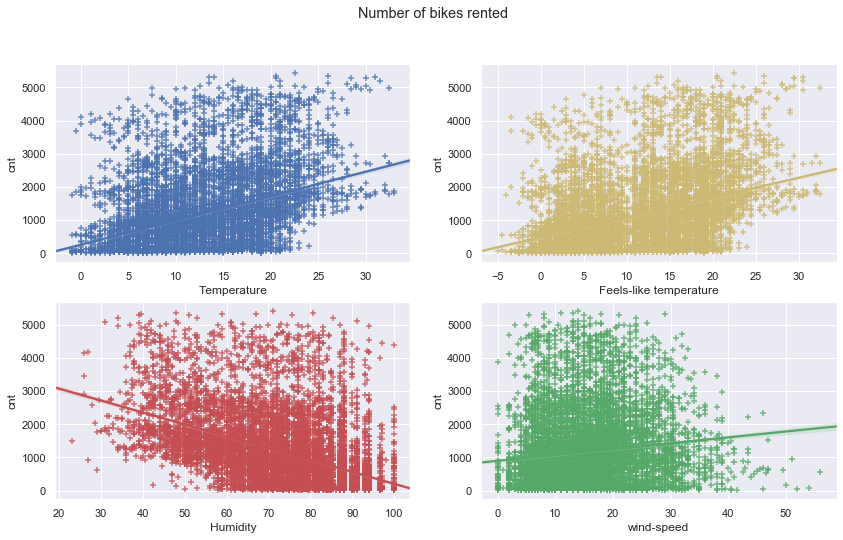

In [13]:
plotting(df2)

### Training data - subset

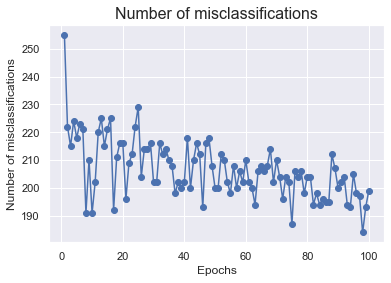

accuracy 89.35%


In [14]:
df_subset1 = df[(df.hour >=8) & (df.hour < 17) & (df.is_weekend == 1)]
print(f'accuracy {training(df_subset1.iloc[:, 2:12], 100) * 100:.2f}%')

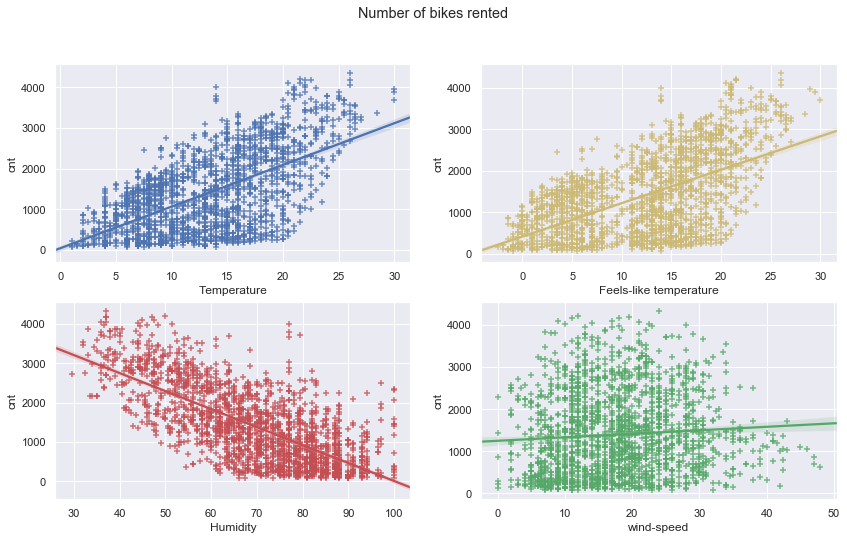

In [15]:
plotting(df_subset1)

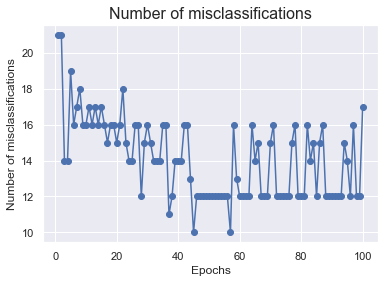

accuracy 89.10%


In [16]:
df_subset2 = df[(df.hour >=12) & (df.hour <= 14) & (df.is_weekend == 1) & (df.season == 2)]
print(f'accuracy {training(df_subset2.iloc[:, 2:12], 100) * 100:.2f}%')

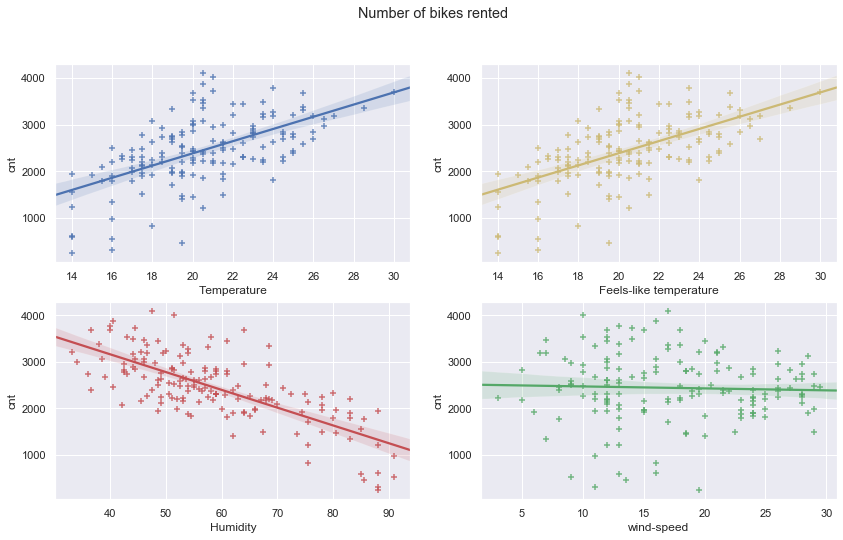

In [17]:
plotting(df_subset2)

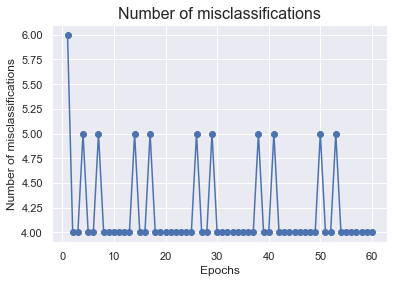

accuracy 93.94%


In [18]:
df_subset3 = df[(df.hour >=12) & (df.hour < 13) & (df.is_weekend == 0) & (df.season == 2) & (df['timestamp'].dt.year == 2015)]
print(f'accuracy {training(df_subset3.iloc[:, 2:12], 60) * 100:.2f}%')

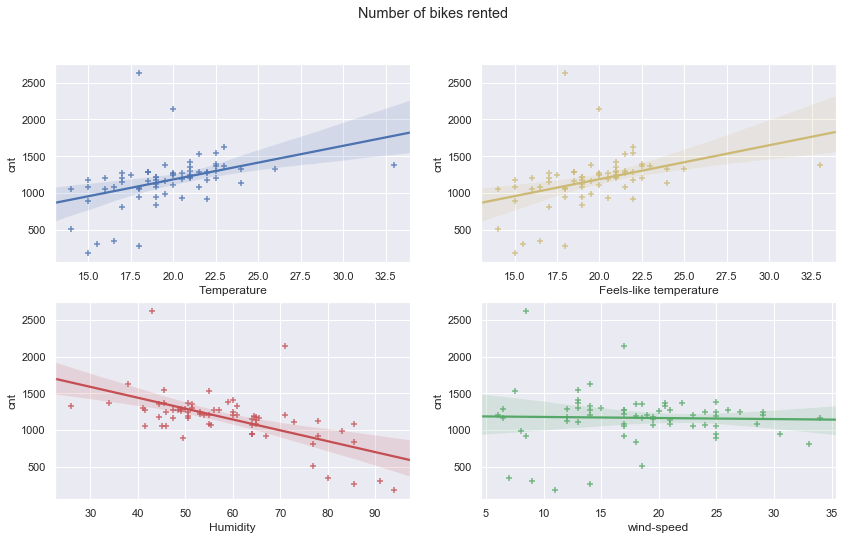

In [19]:
plotting(df_subset3)

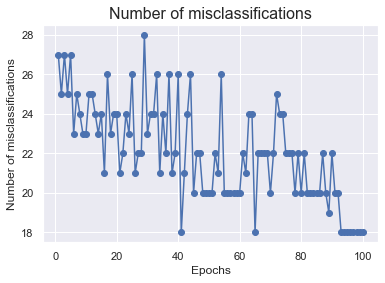

accuracy 88.24%


In [20]:
df_subset4 = df[(df.hour >=12) & (df.hour <= 14) & (df.season == 4) & (df.is_weekend == 1) & (df.cnt < 2500)]
print(f'accuracy {training(df_subset4.iloc[:, 2:12], 100) * 100:.2f}%')

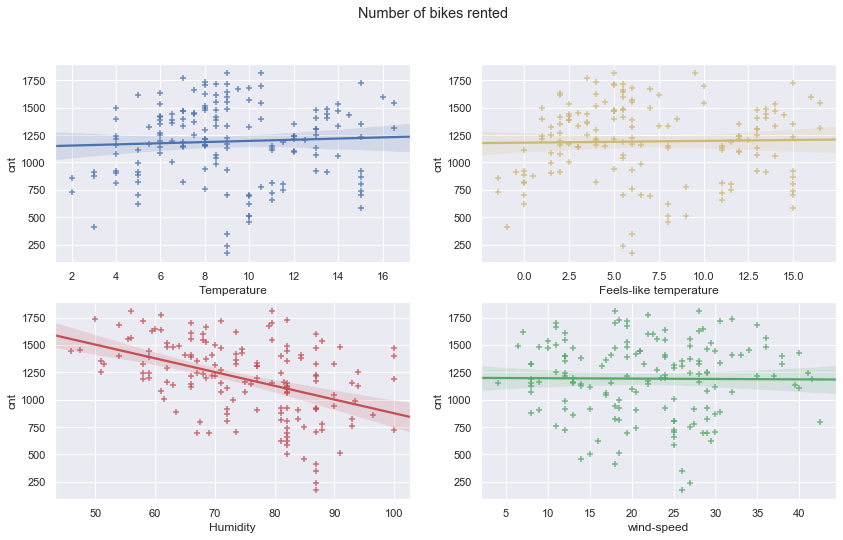

In [21]:
plotting(df_subset4)